In [ ]:
from google.colab import drive
import os
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D, BatchNormalization, Conv2D, GlobalMaxPooling2D, Concatenate
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import  EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.losses import CategoricalCrossentropy
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from PIL import Image
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report

In [ ]:
# https://drive.google.com/file/d/1eNwzro_54h7Rf_lNC5S-k82kFBW_dpQ3/view?usp=sharing

FILE_ID = "1eNwzro_54h7Rf_lNC5S-k82kFBW_dpQ3"

!gdown --id {FILE_ID} -O /content/dataset.7z

/usr/local/lib/python3.12/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=1eNwzro_54h7Rf_lNC5S-k82kFBW_dpQ3
From (redirected): https://drive.google.com/uc?id=1eNwzro_54h7Rf_lNC5S-k82kFBW_dpQ3&confirm=t&uuid=897c8cdb-c4eb-4eb3-8a71-87f706d9af2c
To: /content/dataset.7z
100% 1.08G/1.08G [00:12<00:00, 85.8MB/s]


In [ ]:
!7z x /content/dataset.7z -o/content/


7-Zip [64] 16.02 : Copyright (c) 1999-2016 Igor Pavlov : 2016-05-21
p7zip Version 16.02 (locale=en_US.UTF-8,Utf16=on,HugeFiles=on,64 bits,2 CPUs Intel(R) Xeon(R) CPU @ 2.30GHz (306F0),ASM,AES-NI)

Scanning the drive for archives:
  0M Scan /content/                   1 file, 1082952861 bytes (1033 MiB)

Extracting archive: /content/dataset.7z
 63% 4096 Open              WARNING:
/content/dataset.7z
Can not open the file as [7z] archive
The file is open as [zip] archive

--
Path = /content/dataset.7z
Open WARNING: Can not open the file as [7z] archive
Type = zip
Physical Size = 1082952861

  0%      1% 296 - farm_insects/Africanized Honey Bees (Killer Bees)/aug_0_7948.jpg                                                                             3% 446 - farm_insec

In [ ]:
dataset_path = 'farm_insects'
os.listdir(dataset_path)

['Fall Armyworms',
 'Aphids',
 'Fruit Flies',
 'Corn Earworms',
 'Cabbage Loopers',
 'Colorado Potato Beetles',
 'Thrips',
 'Africanized Honey Bees (Killer Bees)',
 'Spider Mites',
 'Western Corn Rootworms',
 'Tomato Hornworms',
 'Armyworms',
 'Brown Marmorated Stink Bugs']

In [ ]:
classes = sorted([d for d in os.listdir(dataset_path)
                  if os.path.isdir(os.path.join(dataset_path, d))])

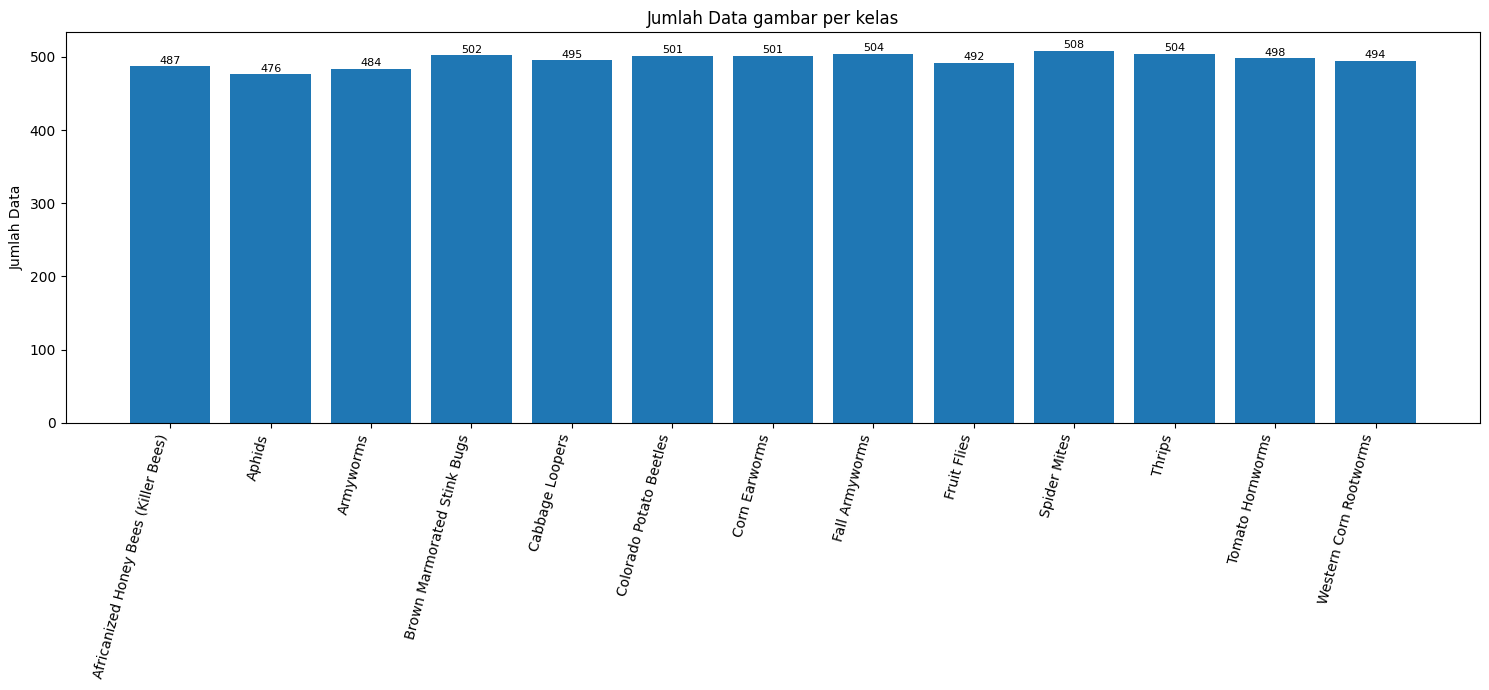

In [ ]:
counts = []

for cls in classes:
    class_path = os.path.join(dataset_path, cls)
    if os.path.isdir(class_path):
        total = len([f for f in os.listdir(class_path)
                     if f.lower().endswith(('jpg','jpeg','png'))])
        counts.append(total)


plt.figure(figsize=(15,7))
x = range(len(classes))

bars = plt.bar(x, counts)

plt.xticks(x, classes, rotation=75, ha='right')
plt.ylabel("Jumlah Data")
plt.title("Jumlah Data gambar per kelas")
plt.tight_layout()


for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + 1, str(height),
             ha='center', va='bottom', fontsize=8)

plt.show()

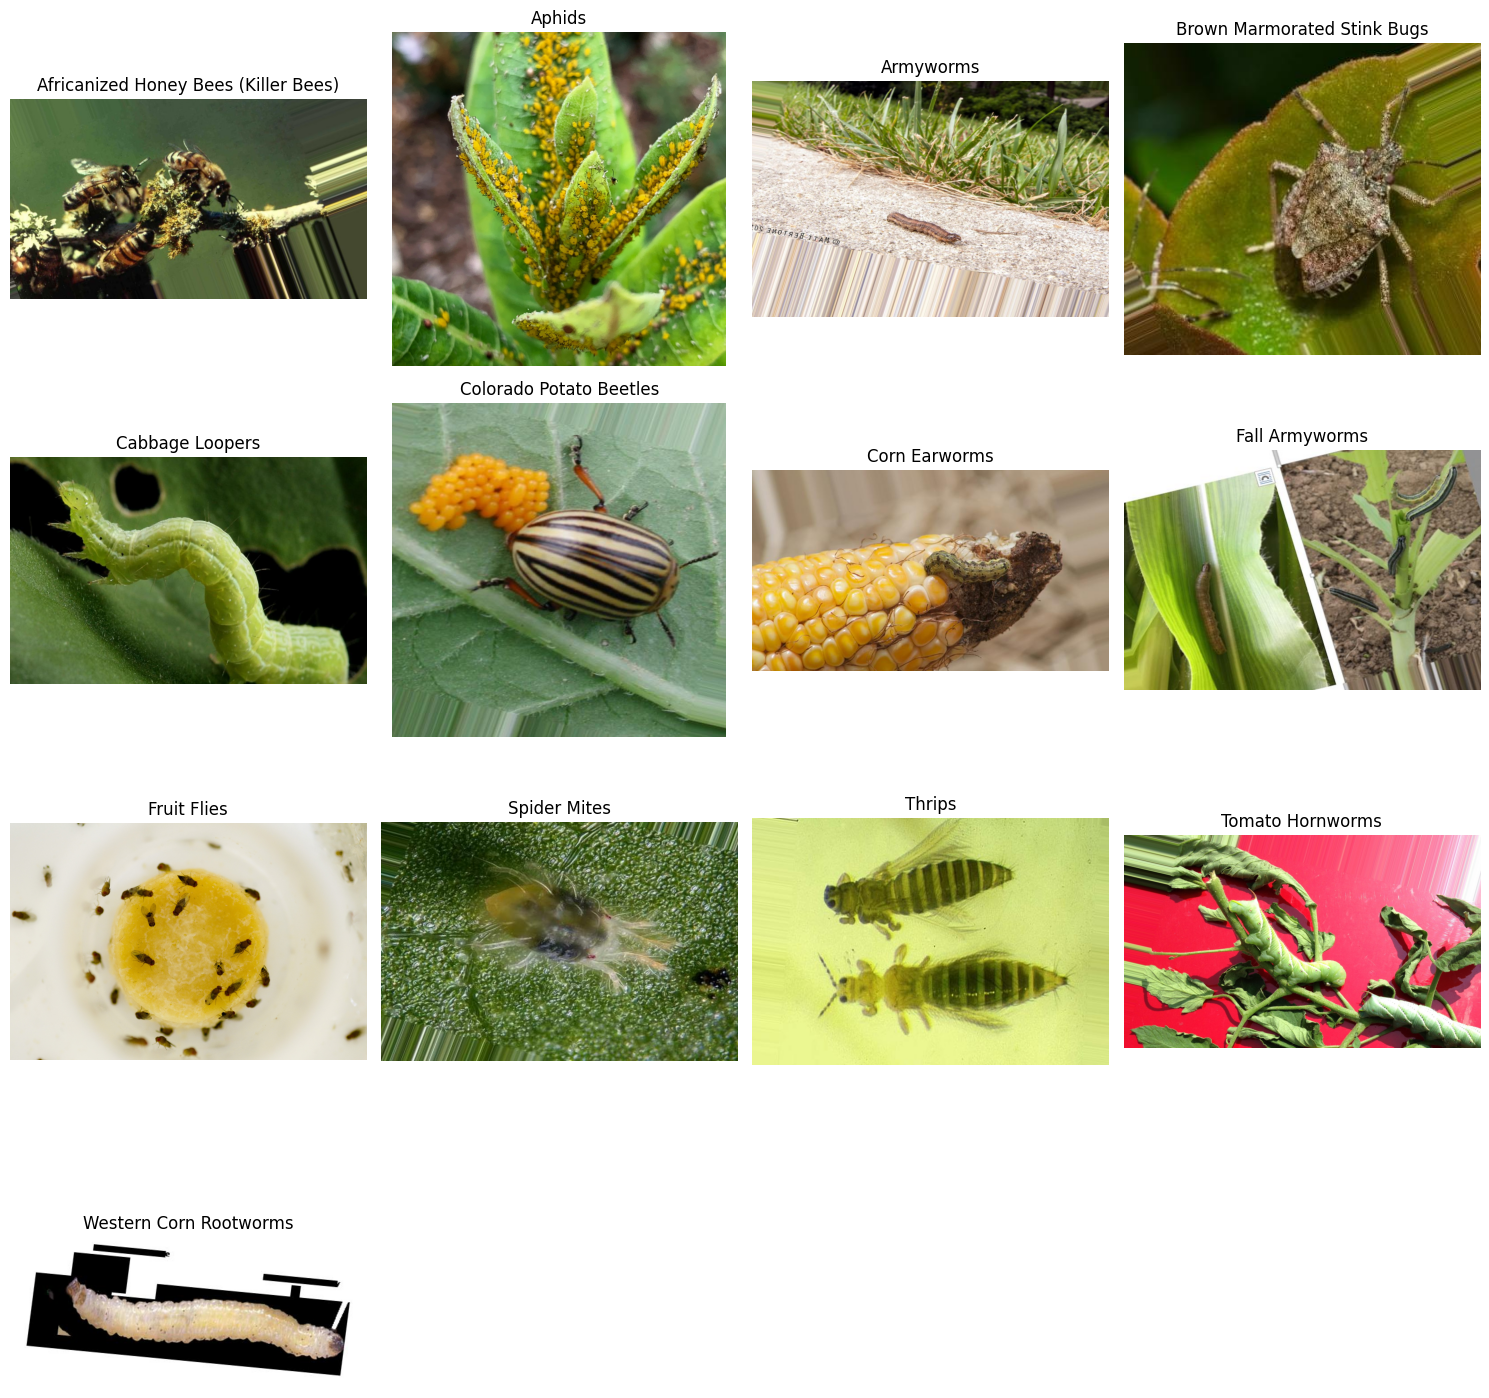

In [ ]:
import random
plt.figure(figsize=(15, 15))

for i, cls in enumerate(classes):
    class_path = os.path.join(dataset_path, cls)

    # Ambil semua file gambar
    images = [f for f in os.listdir(class_path)
              if f.lower().endswith(("jpg", "jpeg", "png"))]

    if len(images) == 0:
        continue

    # Pilih random 1 gambar
    img_path = os.path.join(class_path, random.choice(images))
    img = Image.open(img_path)

    # Plot
    plt.subplot(4, 4, i + 1)
    plt.imshow(img)
    plt.title(cls)
    plt.axis("off")

plt.tight_layout()
plt.show()

In [ ]:
import os
import shutil
import random

# Folder asal dataset
base_dir = 'farm_insects'

# Folder tujuan hasil split
split_dir = 'dataset_split'
train_dir = os.path.join(split_dir, 'train')
val_dir = os.path.join(split_dir, 'val')

# Hapus jika sudah ada, lalu buat ulang
if os.path.exists(split_dir):
    shutil.rmtree(split_dir)
os.makedirs(train_dir)
os.makedirs(val_dir)

# Rasio split
train_ratio = 0.8

# Loop semua kelas
for class_name in os.listdir(base_dir):
    class_path = os.path.join(base_dir, class_name)
    if not os.path.isdir(class_path):
        continue

    # Buat folder kelas di train dan val
    os.makedirs(os.path.join(train_dir, class_name), exist_ok=True)
    os.makedirs(os.path.join(val_dir, class_name), exist_ok=True)

    # Ambil semua gambar
    images = [f for f in os.listdir(class_path) if f.lower().endswith(('jpg','jpeg','png'))]
    random.shuffle(images)

    # Hitung jumlah untuk train dan val
    train_count = int(len(images) * train_ratio)
    train_files = images[:train_count]
    val_files = images[train_count:]

    # Salin ke folder train
    for file in train_files:
        src = os.path.join(class_path, file)
        dst = os.path.join(train_dir, class_name, file)
        shutil.copy(src, dst)

    # Salin ke folder val
    for file in val_files:
        src = os.path.join(class_path, file)
        dst = os.path.join(val_dir, class_name, file)
        shutil.copy(src, dst)

    print(f"{class_name}: {len(train_files)} train | {len(val_files)} val")

print("\nDataset berhasil dibagi ke folder:")
print(f"   - {train_dir}")
print(f"   - {val_dir}")


Fall Armyworms: 403 train | 101 val
Aphids: 380 train | 96 val
Fruit Flies: 393 train | 99 val
Corn Earworms: 400 train | 101 val
Cabbage Loopers: 396 train | 99 val
Colorado Potato Beetles: 400 train | 101 val
Thrips: 403 train | 101 val
Africanized Honey Bees (Killer Bees): 389 train | 98 val
Spider Mites: 406 train | 102 val
Western Corn Rootworms: 395 train | 99 val
Tomato Hornworms: 398 train | 100 val
Armyworms: 387 train | 97 val
Brown Marmorated Stink Bugs: 401 train | 101 val

Dataset berhasil dibagi ke folder:
   - dataset_split/train
   - dataset_split/val


In [ ]:
import zipfile, os

balanced_dir = 'dataset_split'
zip_filename = balanced_dir + '.zip'

with zipfile.ZipFile(zip_filename, 'w', zipfile.ZIP_DEFLATED) as zipf:
    for root, _, files in os.walk(balanced_dir):
        for file in files:
            file_path = os.path.join(root, file)
            zipf.write(file_path, os.path.relpath(file_path, balanced_dir))

print("✅ ZIP selesai dibuat:", zip_filename)

✅ ZIP selesai dibuat: dataset_split.zip


In [ ]:
from google.colab import files
files.download('farm_insects.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=25,
    width_shift_range=0.15,
    height_shift_range=0.15,
    shear_range=0.15,
    zoom_range=0.25,
    brightness_range=[0.7, 1.3],
    horizontal_flip=True,
    vertical_flip=False,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1./255)

train_ds = train_datagen.flow_from_directory(
    'dataset_split/train',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=True
)

val_ds = val_datagen.flow_from_directory(
    'dataset_split/val',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

num_classes = len(train_ds.class_indices)
print("Jumlah kelas:", num_classes)

Found 5151 images belonging to 13 classes.
Found 1295 images belonging to 13 classes.
Jumlah kelas: 13


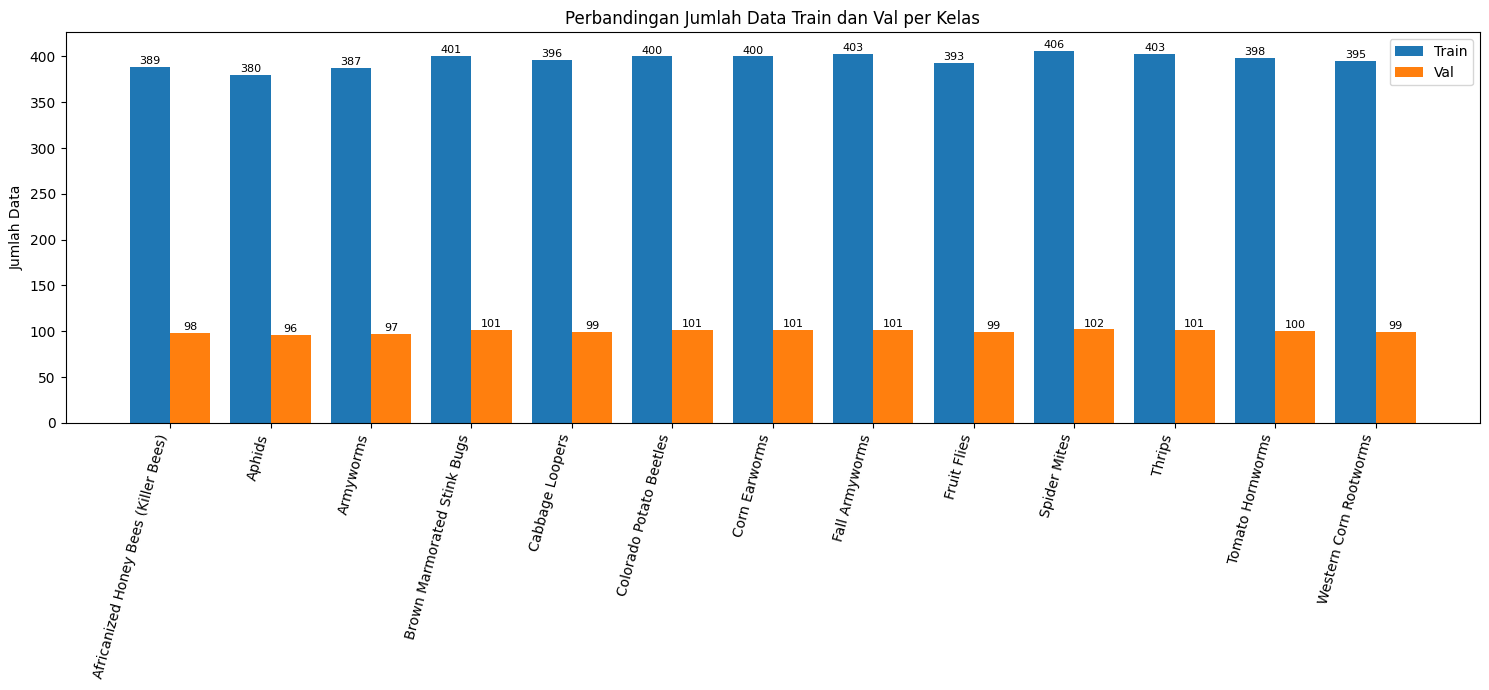

In [ ]:
train_path = os.path.join('dataset_split/train')
val_path   = os.path.join('dataset_split/val')

train_counts = []
val_counts = []

for cls in classes:
    train_cls_path = os.path.join(train_path, cls)
    val_cls_path   = os.path.join(val_path, cls)

    train_count = len([f for f in os.listdir(train_cls_path)
                       if f.lower().endswith(('jpg','jpeg','png'))])
    val_count = len([f for f in os.listdir(val_cls_path)
                     if f.lower().endswith(('jpg','jpeg','png'))])

    train_counts.append(train_count)
    val_counts.append(val_count)


plt.figure(figsize=(15,7))
x = range(len(classes))
width = 0.4

bars_train = plt.bar([i - width/2 for i in x], train_counts, width, label="Train")
bars_val   = plt.bar([i + width/2 for i in x], val_counts, width, label="Val")

plt.xticks(x, classes, rotation=75, ha='right')
plt.ylabel("Jumlah Data")
plt.title("Perbandingan Jumlah Data Train dan Val per Kelas (Auto from Split)")
plt.legend()
plt.tight_layout()

for bar in bars_train:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + 1, str(height),
             ha='center', va='bottom', fontsize=8)

for bar in bars_val:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + 1, str(height),
             ha='center', va='bottom', fontsize=8)

plt.show()


In [ ]:
base_model = MobileNetV2(
    weights='imagenet',
    include_top=False,
    input_shape=(224, 224, 3)
)
base_model.trainable = False

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:

x = base_model.output
x1 = GlobalAveragePooling2D()(x)
x2 = GlobalMaxPooling2D()(x)

# Gabungkan dua tipe pooling biar model tangkap lebih banyak detail
x = Concatenate()([x1, x2])

x = BatchNormalization()(x)
x = Dropout(0.5)(x)

# Dense layer kecil untuk menangkap perbedaan halus
x = Dense(512, activation='relu', kernel_regularizer='l2')(x)
x = BatchNormalization()(x)
x = Dropout(0.4)(x)

# Output akhir
predictions = Dense(num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

In [ ]:
class_names = list(train_ds.class_indices.keys())
print(class_names)

['Africanized Honey Bees (Killer Bees)', 'Aphids', 'Armyworms', 'Brown Marmorated Stink Bugs', 'Cabbage Loopers', 'Colorado Potato Beetles', 'Corn Earworms', 'Fall Armyworms', 'Fruit Flies', 'Spider Mites', 'Thrips', 'Tomato Hornworms', 'Western Corn Rootworms']


In [ ]:
model.compile(
    optimizer=Adam(learning_rate=1e-3),
    loss=CategoricalCrossentropy(label_smoothing=0.1),
    metrics=['accuracy']
)

In [ ]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 3,588,175 (13.69 MB)

 Trainable params: 3,279,757 (12.51 MB)

 Non-trainable params: 308,416 (1.18 MB)

 Optimizer params: 2 (12.00 B)

In [ ]:
checkpoint = ModelCheckpoint(
    'mobilenetv2_best_finegrained.h5',
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1
)

earlystop = EarlyStopping(
    monitor='val_loss',
    patience=6,
    restore_best_weights=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    min_lr=1e-6,
    verbose=1
)

In [ ]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=30,
    callbacks=[checkpoint, earlystop, reduce_lr]
)

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
133/161 ━━━━━━━━━━━━━━━━━━━━ 19s 703ms/step - accuracy: 0.6598 - loss: 9.5159

/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 688ms/step - accuracy: 0.6761 - loss: 9.2418
Epoch 1: val_accuracy improved from -inf to 0.86873, saving model to mobilenetv2_best_finegrained.h5


161/161 ━━━━━━━━━━━━━━━━━━━━ 157s 855ms/step - accuracy: 0.6766 - loss: 9.2324 - val_accuracy: 0.8687 - val_loss: 5.0453 - learning_rate: 0.0010
Epoch 2/30
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 606ms/step - accuracy: 0.8322 - loss: 4.4513
Epoch 2: val_accuracy improved from 0.86873 to 0.89575, saving model to mobilenetv2_best_finegrained.h5


161/161 ━━━━━━━━━━━━━━━━━━━━ 109s 677ms/step - accuracy: 0.8322 - loss: 4.4477 - val_accuracy: 0.8958 - val_loss: 2.7691 - learning_rate: 0.0010
Epoch 3/30
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 606ms/step - accuracy: 0.8485 - loss: 2.6322
Epoch 3: val_accuracy did not improve from 0.89575
161/161 ━━━━━━━━━━━━━━━━━━━━ 109s 675ms/step - accuracy: 0.8485 - loss: 2.6311 - val_accuracy: 0.8958 - val_loss: 2.0101 - learning_rate: 0.0010
Epoch 4/30
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 612ms/step - accuracy: 0.8633 - loss: 2.0476
Epoch 4: val_accuracy improved from 0.89575 to 0.90656, saving model to mobilenetv2_best_finegrained.h5


161/161 ━━━━━━━━━━━━━━━━━━━━ 110s 684ms/step - accuracy: 0.8633 - loss: 2.0473 - val_accuracy: 0.9066 - val_loss: 1.7643 - learning_rate: 0.0010
Epoch 5/30
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 606ms/step - accuracy: 0.8607 - loss: 1.8722
Epoch 5: val_accuracy improved from 0.90656 to 0.90734, saving model to mobilenetv2_best_finegrained.h5


161/161 ━━━━━━━━━━━━━━━━━━━━ 109s 676ms/step - accuracy: 0.8606 - loss: 1.8722 - val_accuracy: 0.9073 - val_loss: 1.7149 - learning_rate: 0.0010
Epoch 6/30
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 619ms/step - accuracy: 0.8630 - loss: 1.8084
Epoch 6: val_accuracy did not improve from 0.90734
161/161 ━━━━━━━━━━━━━━━━━━━━ 111s 689ms/step - accuracy: 0.8630 - loss: 1.8084 - val_accuracy: 0.9050 - val_loss: 1.6700 - learning_rate: 0.0010
Epoch 7/30
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 612ms/step - accuracy: 0.8609 - loss: 1.7475
Epoch 7: val_accuracy did not improve from 0.90734
161/161 ━━━━━━━━━━━━━━━━━━━━ 110s 682ms/step - accuracy: 0.8609 - loss: 1.7476 - val_accuracy: 0.8958 - val_loss: 1.6490 - learning_rate: 0.0010
Epoch 8/30
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 612ms/step - accuracy: 0.8637 - loss: 1.7167
Epoch 8: val_accuracy did not improve from 0.90734
161/161 ━━━━━━━━━━━━━━━━━━━━ 110s 681ms/step - accuracy: 0.8637 - loss: 1.7168 - val_accuracy: 0.8927 - val_loss: 1.6368 - learning_rate: 0.0010
Epo

161/161 ━━━━━━━━━━━━━━━━━━━━ 109s 678ms/step - accuracy: 0.8937 - loss: 1.3920 - val_accuracy: 0.9089 - val_loss: 1.3181 - learning_rate: 5.0000e-04
Epoch 15/30
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 620ms/step - accuracy: 0.8928 - loss: 1.3835
Epoch 15: val_accuracy improved from 0.90888 to 0.91197, saving model to mobilenetv2_best_finegrained.h5


161/161 ━━━━━━━━━━━━━━━━━━━━ 112s 694ms/step - accuracy: 0.8928 - loss: 1.3836 - val_accuracy: 0.9120 - val_loss: 1.3336 - learning_rate: 5.0000e-04
Epoch 16/30
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 617ms/step - accuracy: 0.8917 - loss: 1.3664
Epoch 16: val_accuracy did not improve from 0.91197
161/161 ━━━━━━━━━━━━━━━━━━━━ 110s 686ms/step - accuracy: 0.8916 - loss: 1.3666 - val_accuracy: 0.9066 - val_loss: 1.3123 - learning_rate: 5.0000e-04
Epoch 17/30
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 621ms/step - accuracy: 0.8917 - loss: 1.3566
Epoch 17: val_accuracy did not improve from 0.91197
161/161 ━━━━━━━━━━━━━━━━━━━━ 111s 690ms/step - accuracy: 0.8917 - loss: 1.3567 - val_accuracy: 0.8981 - val_loss: 1.3341 - learning_rate: 5.0000e-04
Epoch 18/30
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 615ms/step - accuracy: 0.9000 - loss: 1.3678
Epoch 18: val_accuracy improved from 0.91197 to 0.91506, saving model to mobilenetv2_best_finegrained.h5


161/161 ━━━━━━━━━━━━━━━━━━━━ 110s 687ms/step - accuracy: 0.8999 - loss: 1.3679 - val_accuracy: 0.9151 - val_loss: 1.3193 - learning_rate: 5.0000e-04
Epoch 19/30
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 621ms/step - accuracy: 0.8922 - loss: 1.3854
Epoch 19: val_accuracy improved from 0.91506 to 0.91737, saving model to mobilenetv2_best_finegrained.h5



Epoch 19: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
161/161 ━━━━━━━━━━━━━━━━━━━━ 111s 692ms/step - accuracy: 0.8922 - loss: 1.3855 - val_accuracy: 0.9174 - val_loss: 1.3201 - learning_rate: 5.0000e-04
Epoch 20/30
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 608ms/step - accuracy: 0.9041 - loss: 1.3329
Epoch 20: val_accuracy improved from 0.91737 to 0.93050, saving model to mobilenetv2_best_finegrained.h5


161/161 ━━━━━━━━━━━━━━━━━━━━ 109s 679ms/step - accuracy: 0.9041 - loss: 1.3327 - val_accuracy: 0.9305 - val_loss: 1.1713 - learning_rate: 2.5000e-04
Epoch 21/30
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 608ms/step - accuracy: 0.9127 - loss: 1.2103
Epoch 21: val_accuracy improved from 0.93050 to 0.93745, saving model to mobilenetv2_best_finegrained.h5


161/161 ━━━━━━━━━━━━━━━━━━━━ 109s 679ms/step - accuracy: 0.9127 - loss: 1.2102 - val_accuracy: 0.9375 - val_loss: 1.1156 - learning_rate: 2.5000e-04
Epoch 22/30
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 612ms/step - accuracy: 0.9122 - loss: 1.1739
Epoch 22: val_accuracy improved from 0.93745 to 0.93977, saving model to mobilenetv2_best_finegrained.h5


161/161 ━━━━━━━━━━━━━━━━━━━━ 110s 682ms/step - accuracy: 0.9122 - loss: 1.1739 - val_accuracy: 0.9398 - val_loss: 1.0866 - learning_rate: 2.5000e-04
Epoch 23/30
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 612ms/step - accuracy: 0.9191 - loss: 1.1408
Epoch 23: val_accuracy did not improve from 0.93977
161/161 ━━━━━━━━━━━━━━━━━━━━ 110s 681ms/step - accuracy: 0.9191 - loss: 1.1409 - val_accuracy: 0.9375 - val_loss: 1.0942 - learning_rate: 2.5000e-04
Epoch 24/30
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 607ms/step - accuracy: 0.9127 - loss: 1.1471
Epoch 24: val_accuracy did not improve from 0.93977
161/161 ━━━━━━━━━━━━━━━━━━━━ 109s 677ms/step - accuracy: 0.9126 - loss: 1.1472 - val_accuracy: 0.9344 - val_loss: 1.0984 - learning_rate: 2.5000e-04
Epoch 25/30
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 612ms/step - accuracy: 0.9180 - loss: 1.1426
Epoch 25: val_accuracy did not improve from 0.93977
161/161 ━━━━━━━━━━━━━━━━━━━━ 109s 680ms/step - accuracy: 0.9180 - loss: 1.1427 - val_accuracy: 0.9367 - val_loss: 1.0829 - learnin

161/161 ━━━━━━━━━━━━━━━━━━━━ 109s 679ms/step - accuracy: 0.9309 - loss: 1.1138 - val_accuracy: 0.9413 - val_loss: 1.0796 - learning_rate: 2.5000e-04
Epoch 27/30
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 607ms/step - accuracy: 0.9146 - loss: 1.1409
Epoch 27: val_accuracy did not improve from 0.94131
161/161 ━━━━━━━━━━━━━━━━━━━━ 109s 677ms/step - accuracy: 0.9146 - loss: 1.1409 - val_accuracy: 0.9336 - val_loss: 1.0655 - learning_rate: 2.5000e-04
Epoch 28/30
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 601ms/step - accuracy: 0.9238 - loss: 1.1134
Epoch 28: val_accuracy improved from 0.94131 to 0.94440, saving model to mobilenetv2_best_finegrained.h5


161/161 ━━━━━━━━━━━━━━━━━━━━ 108s 672ms/step - accuracy: 0.9237 - loss: 1.1135 - val_accuracy: 0.9444 - val_loss: 1.0715 - learning_rate: 2.5000e-04
Epoch 29/30
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 610ms/step - accuracy: 0.9235 - loss: 1.1195
Epoch 29: val_accuracy improved from 0.94440 to 0.94903, saving model to mobilenetv2_best_finegrained.h5


161/161 ━━━━━━━━━━━━━━━━━━━━ 110s 684ms/step - accuracy: 0.9234 - loss: 1.1196 - val_accuracy: 0.9490 - val_loss: 1.0650 - learning_rate: 2.5000e-04
Epoch 30/30
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 619ms/step - accuracy: 0.9269 - loss: 1.1130
Epoch 30: val_accuracy did not improve from 0.94903
161/161 ━━━━━━━━━━━━━━━━━━━━ 111s 689ms/step - accuracy: 0.9269 - loss: 1.1131 - val_accuracy: 0.9459 - val_loss: 1.0590 - learning_rate: 2.5000e-04
Restoring model weights from the end of the best epoch: 30.


In [ ]:
for layer in base_model.layers[-60:]:
    layer.trainable = True

model.compile(
    optimizer=Adam(learning_rate=1e-5),
    loss=CategoricalCrossentropy(label_smoothing=0.1),
    metrics=['accuracy']
)

history_finetune = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=20,
    callbacks=[checkpoint, earlystop, reduce_lr]
)

Epoch 1/20
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 689ms/step - accuracy: 0.8701 - loss: 1.2506
Epoch 1: val_accuracy did not improve from 0.94903
161/161 ━━━━━━━━━━━━━━━━━━━━ 157s 814ms/step - accuracy: 0.8702 - loss: 1.2504 - val_accuracy: 0.9320 - val_loss: 1.1480 - learning_rate: 1.0000e-05
Epoch 2/20
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 623ms/step - accuracy: 0.8976 - loss: 1.1723
Epoch 2: val_accuracy did not improve from 0.94903
161/161 ━━━━━━━━━━━━━━━━━━━━ 111s 693ms/step - accuracy: 0.8976 - loss: 1.1723 - val_accuracy: 0.9313 - val_loss: 1.1519 - learning_rate: 1.0000e-05
Epoch 3/20
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 616ms/step - accuracy: 0.9140 - loss: 1.1339
Epoch 3: val_accuracy did not improve from 0.94903
161/161 ━━━━━━━━━━━━━━━━━━━━ 110s 684ms/step - accuracy: 0.9140 - loss: 1.1339 - val_accuracy: 0.9367 - val_loss: 1.1227 - learning_rate: 1.0000e-05
Epoch 4/20
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 610ms/step - accuracy: 0.9138 - loss: 1.1370
Epoch 4: val_accuracy did not improve from 0.949

161/161 ━━━━━━━━━━━━━━━━━━━━ 111s 690ms/step - accuracy: 0.9310 - loss: 1.0741 - val_accuracy: 0.9514 - val_loss: 1.0318 - learning_rate: 1.0000e-05
Epoch 8/20
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 637ms/step - accuracy: 0.9304 - loss: 1.0652
Epoch 8: val_accuracy improved from 0.95135 to 0.95290, saving model to mobilenetv2_best_finegrained.h5


161/161 ━━━━━━━━━━━━━━━━━━━━ 114s 710ms/step - accuracy: 0.9304 - loss: 1.0651 - val_accuracy: 0.9529 - val_loss: 1.0180 - learning_rate: 1.0000e-05
Epoch 9/20
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 629ms/step - accuracy: 0.9424 - loss: 1.0430
Epoch 9: val_accuracy improved from 0.95290 to 0.95367, saving model to mobilenetv2_best_finegrained.h5


161/161 ━━━━━━━━━━━━━━━━━━━━ 113s 702ms/step - accuracy: 0.9424 - loss: 1.0430 - val_accuracy: 0.9537 - val_loss: 1.0049 - learning_rate: 1.0000e-05
Epoch 10/20
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 623ms/step - accuracy: 0.9483 - loss: 1.0265
Epoch 10: val_accuracy improved from 0.95367 to 0.95598, saving model to mobilenetv2_best_finegrained.h5


161/161 ━━━━━━━━━━━━━━━━━━━━ 112s 696ms/step - accuracy: 0.9482 - loss: 1.0265 - val_accuracy: 0.9560 - val_loss: 0.9935 - learning_rate: 1.0000e-05
Epoch 11/20
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 627ms/step - accuracy: 0.9424 - loss: 1.0186
Epoch 11: val_accuracy improved from 0.95598 to 0.95676, saving model to mobilenetv2_best_finegrained.h5


161/161 ━━━━━━━━━━━━━━━━━━━━ 113s 701ms/step - accuracy: 0.9425 - loss: 1.0186 - val_accuracy: 0.9568 - val_loss: 0.9795 - learning_rate: 1.0000e-05
Epoch 12/20
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 621ms/step - accuracy: 0.9509 - loss: 1.0143
Epoch 12: val_accuracy did not improve from 0.95676
161/161 ━━━━━━━━━━━━━━━━━━━━ 111s 690ms/step - accuracy: 0.9509 - loss: 1.0143 - val_accuracy: 0.9544 - val_loss: 0.9706 - learning_rate: 1.0000e-05
Epoch 13/20
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 620ms/step - accuracy: 0.9459 - loss: 1.0110
Epoch 13: val_accuracy improved from 0.95676 to 0.95753, saving model to mobilenetv2_best_finegrained.h5


161/161 ━━━━━━━━━━━━━━━━━━━━ 112s 694ms/step - accuracy: 0.9460 - loss: 1.0110 - val_accuracy: 0.9575 - val_loss: 0.9607 - learning_rate: 1.0000e-05
Epoch 14/20
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 628ms/step - accuracy: 0.9517 - loss: 0.9934
Epoch 14: val_accuracy did not improve from 0.95753
161/161 ━━━━━━━━━━━━━━━━━━━━ 122s 757ms/step - accuracy: 0.9517 - loss: 0.9934 - val_accuracy: 0.9568 - val_loss: 0.9510 - learning_rate: 1.0000e-05
Epoch 15/20
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 631ms/step - accuracy: 0.9567 - loss: 0.9834
Epoch 15: val_accuracy improved from 0.95753 to 0.95830, saving model to mobilenetv2_best_finegrained.h5


161/161 ━━━━━━━━━━━━━━━━━━━━ 113s 705ms/step - accuracy: 0.9567 - loss: 0.9834 - val_accuracy: 0.9583 - val_loss: 0.9410 - learning_rate: 1.0000e-05
Epoch 16/20
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 622ms/step - accuracy: 0.9579 - loss: 0.9736
Epoch 16: val_accuracy improved from 0.95830 to 0.95985, saving model to mobilenetv2_best_finegrained.h5


161/161 ━━━━━━━━━━━━━━━━━━━━ 112s 694ms/step - accuracy: 0.9579 - loss: 0.9736 - val_accuracy: 0.9598 - val_loss: 0.9331 - learning_rate: 1.0000e-05
Epoch 17/20
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 628ms/step - accuracy: 0.9542 - loss: 0.9660
Epoch 17: val_accuracy improved from 0.95985 to 0.96448, saving model to mobilenetv2_best_finegrained.h5


161/161 ━━━━━━━━━━━━━━━━━━━━ 113s 705ms/step - accuracy: 0.9542 - loss: 0.9660 - val_accuracy: 0.9645 - val_loss: 0.9255 - learning_rate: 1.0000e-05
Epoch 18/20
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 630ms/step - accuracy: 0.9609 - loss: 0.9597
Epoch 18: val_accuracy improved from 0.96448 to 0.96757, saving model to mobilenetv2_best_finegrained.h5


161/161 ━━━━━━━━━━━━━━━━━━━━ 113s 701ms/step - accuracy: 0.9609 - loss: 0.9597 - val_accuracy: 0.9676 - val_loss: 0.9159 - learning_rate: 1.0000e-05
Epoch 19/20
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 622ms/step - accuracy: 0.9658 - loss: 0.9470
Epoch 19: val_accuracy improved from 0.96757 to 0.97066, saving model to mobilenetv2_best_finegrained.h5


161/161 ━━━━━━━━━━━━━━━━━━━━ 112s 697ms/step - accuracy: 0.9658 - loss: 0.9470 - val_accuracy: 0.9707 - val_loss: 0.9077 - learning_rate: 1.0000e-05
Epoch 20/20
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 627ms/step - accuracy: 0.9607 - loss: 0.9455
Epoch 20: val_accuracy did not improve from 0.97066
161/161 ━━━━━━━━━━━━━━━━━━━━ 112s 694ms/step - accuracy: 0.9608 - loss: 0.9455 - val_accuracy: 0.9707 - val_loss: 0.9020 - learning_rate: 1.0000e-05
Restoring model weights from the end of the best epoch: 20.


In [ ]:
model.save('serangga_berbahaya.h5')

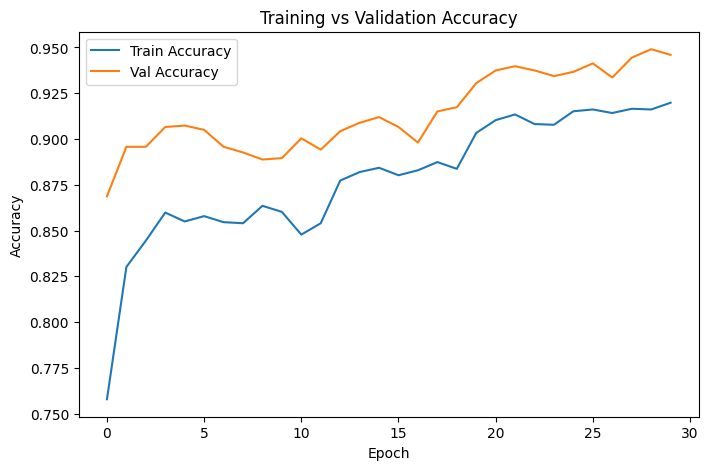

In [ ]:
import matplotlib.pyplot as plt
# Plot Accuracy
plt.figure(figsize=(8,5))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

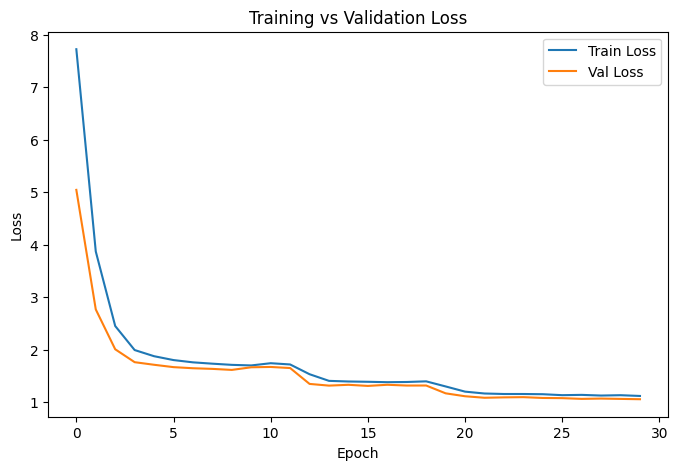

In [ ]:
# Plot Loss
plt.figure(figsize=(8,5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Training vs Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
train_loss, train_acc = model.evaluate(train_ds, verbose=0)
val_loss, val_acc = model.evaluate(val_ds, verbose=0)

print(f"Train acc: {train_acc:.3f}, Val acc: {val_acc:.3f}")
print(f"Train loss: {train_loss:.3f}, Val loss: {val_loss:.3f}")

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Train acc: 0.979, Val acc: 0.982
Train loss: 0.874, Val loss: 0.863


In [ ]:
model = tf.keras.models.load_model("serangga_berbahaya.h5")

In [ ]:
from tensorflow.keras.preprocessing import image_dataset_from_directory

test_datagen = ImageDataGenerator(rescale=1./255)
test_ds = test_datagen.flow_from_directory(
    'dataset_split/val',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

Found 1295 images belonging to 13 classes.


In [ ]:
class_names = list(test_ds.class_indices.keys())


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


 9/41 ━━━━━━━━━━━━━━━━━━━━ 8s 272ms/step

/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


41/41 ━━━━━━━━━━━━━━━━━━━━ 10s 250ms/step


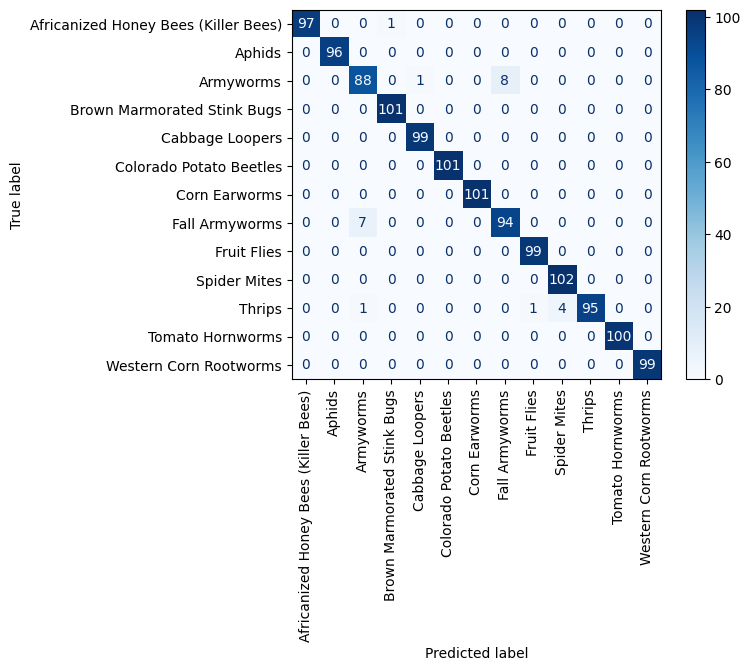

In [ ]:
y_true = test_ds.classes
y_pred_probs = model.predict(test_ds)
y_pred = np.argmax(y_pred_probs, axis=1)

cm = confusion_matrix(y_true, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(xticks_rotation='vertical', cmap='Blues', values_format='d')
plt.show()

In [ ]:
print(classification_report(y_true, y_pred, target_names=class_names))


                                      precision    recall  f1-score   support

Africanized Honey Bees (Killer Bees)       1.00      0.99      0.99        98
                              Aphids       1.00      1.00      1.00        96
                           Armyworms       0.92      0.91      0.91        97
         Brown Marmorated Stink Bugs       0.99      1.00      1.00       101
                     Cabbage Loopers       0.99      1.00      0.99        99
             Colorado Potato Beetles       1.00      1.00      1.00       101
                       Corn Earworms       1.00      1.00      1.00       101
                      Fall Armyworms       0.92      0.93      0.93       101
                         Fruit Flies       0.99      1.00      0.99        99
                        Spider Mites       0.96      1.00      0.98       102
                              Thrips       1.00      0.94      0.97       101
                    Tomato Hornworms       1.00      1.00      

In [ ]:
img_path = 'images.webp'

# Preprocessing gambar
img = image.load_img(img_path, target_size=(224, 224))  # resize ke 224x224
img_array = image.img_to_array(img)                     # ubah ke array
img_array = np.expand_dims(img_array, axis=0)           # tambah dimensi batch
img_array = img_array / 255.0

In [ ]:
score = model.predict(img_array)

predicted_class = class_names[np.argmax(score)]
confidence = 100 * np.max(score)

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


Prediksi: Aphids
Confidence: 79.56%


(np.float64(-0.5), np.float64(311.5), np.float64(311.5), np.float64(-0.5))

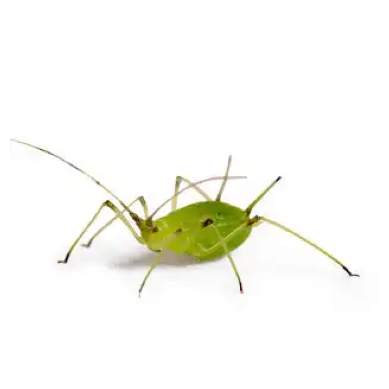

In [ ]:
print(f"Prediksi: {predicted_class}")
print(f"Confidence: {confidence:.2f}%")
plt.imshow(img)
plt.axis('off')